# Appendix E: Estimating Rs and Cm
**Appendix NOT SURE WHERE TO PUT THIS**

During a patch clamp experiment, estimates of $R_s$ and $C_m$ must be made to facilitate slow capacitance and series resistance compensation.
Here we review two methods: A "one-shot" method, that uses current measured during a test pulse without $R_s$ or $C_m$ compensation to make a single prediction, and an "iterative" method, that uses currents measured during successive test pulses while $R_s$ and $C_m$ compensations are refined.

## One-shot approach

In this approach, we follow the pCLAMP 9 User Guide Rev D, as available from [Molecular devices](https://support.moleculardevices.com/s/article/pCLAMP-Software-Manual-Download-Page), starting on page 229.
(The formatting deteriorates in subsequent editions).

A cell is attached to the pipette, the fast artefact has been cancelled out, but no $R_s$ compensation or slow transient cancellation has been applied.

A periodic step protocol is applied, consisting of repeating high ($V_1$) and low ($V_2$) steps of equal duration $T$.
Both steps are analysed identically, so we will discuss only the step at $V_c = V_1$.

<img src="resources/rscm-2-protocol.png" style="margin:auto" />

**TODO: Show slant of upstroke in diagram**

The following quantities are measured:

1. The mean currents in the last 20% of each step, yielding $I_1$ and $I_2$
2. The area under the current curve, yielding $Q$
3. A single exponential fit is performed, yielding $\tau$.

The fit is described as a "fast logarithmic exponential fit ... using a look-up table for the log transforms", suggesting a fit to $\log(I)$, probably after transposing and inverting for step 2.
It is unclear whether $I_1$ and $I_2$ are used in or derived from this step, or whether no info is shared between the estimates.

To analyse this, they start with a simplified model of the cell.

<img src="resources/rscm-1-circuit.png" style="margin:auto" />

The command potential (no $V_p$ or delays etc) is applied to the series resistance $R_s$, causing a voltage drop to $V_m$.
The cell is represented by its capacitance $C_m$ and a membrane resistance $R_m$.
No leak or offsets are included.

The current through $R_s$ is given by

\begin{align}
I = \frac{V_c - V_m}{R_s} = \frac{V_m}{R_m} + C_m \dot{V}_m
\end{align}

We can use this relation to write a model for $V_m$:

\begin{align}
\dot{V}_m = \frac{\frac{R_m}{R_m + R_s}V_c - V_m}{\frac{R_mR_s}{R_m+R_s}C_m} = \frac{V_\infty - V}{\tau}
\end{align}

where, for the first step 
\begin{align}
V_\infty = \frac{R_m}{R_m+R_s}V_1 & \quad & V_0 = \frac{R_m}{R_m+R_s}V_2
\end{align}

and 
\begin{align}
V(t) = V_\infty - \left(V_\infty - V_0\right) e^{-t/\tau}
\end{align}

Alternatively, we can write a model for $I$ as 

\begin{align}
\dot{I} = \frac{\frac{V_c}{R_s + R_m} - I}{\frac{R_sR_m}{R_s+R_m}C_m} + \frac{\dot{V}_c}{R_s}
        = \frac{I_\infty - I}{\tau} + \frac{\dot{V}_c}{R_s}
\end{align}

analysing only the part of the first step where $V_c$ is constant, we can write

\begin{align}
I_\infty = \frac{1}{R_m + R_s} V_1   &\quad&
I_0 = \frac{V_1 - V_0}{R_s}
    = \frac{V_1 - \frac{R_m}{R_m+R_s}V_2}{R_s}
\end{align}

and 
\begin{align}
I(t) = I_\infty - \left(I_\infty - I_0\right) e^{-t/\tau}
\end{align}

In [1]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mA = myokit.parse_model('''
[[model]]
#amp.I_obs = 0
amp.Vm = -70

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rs = 11.7e-3 [GOhm] in [GOhm]
Cm = 31.89 [pF] in [pF]
Rm = 0.5003 [GOhm] in [GOhm]
Vc = 1 [mV] * engine.pace
    in [mV]
dot(Vm) = (Rm * I_obs - Vm) / (Rm * Cm)
    in [mV]
I_obs = (Vc - Vm) / Rs
    in [pA]
''')
mA.check_units(myokit.UNIT_STRICT)

# Get model constants
Rs = mA.get('amp.Rs').eval()
Rm = mA.get('amp.Rm').eval()
Cm = mA.get('amp.Cm').eval()

In [7]:
T = 10
V1 = -60
V2 = -70
dV = V1 - V2

p = myokit.Protocol()
p.schedule(start=0, level=V1, duration=T, period=2*T)
p.schedule(start=T, level=V2, duration=T, period=2*T)

In [8]:
sA = myokit.Simulation(mA, p)
sA.set_tolerance(1e-15, 1e-15)
sA.set_max_step_size(1e-3)
sA.pre(2*T)
dA = sA.run(2*T).npview()

-68.400390625 -58.62890624999999 0.3645867849609375
717.9821047008547 -117.1875


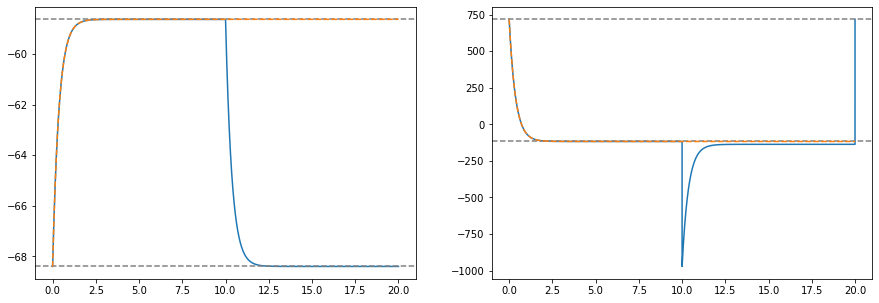

In [18]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(dA.time(), dA['amp.Vm'])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(dA.time(), dA['amp.I_obs'])

# Calculate analytical solutions for V
V0 = Rm / (Rm + Rs) * V2
V8 = Rm / (Rm + Rs) * V1
tau = (Rm * Rs) / (Rm + Rs) * Cm
print(V0, V8, tau)

# Show limits and exponential fit
ax1.axhline(V0, color='grey', ls='--')
ax1.axhline(V00, color='grey', ls='--')
ax1.plot(dA.time(), V8 - (V8 - V0) * np.exp(-dA.time() / tau), '--')

# Calculate analytical solutions for I
I0 = (V1 - Rm / (Rm + Rs) * V2) / Rs
I8 = 1 / (Rm + Rs) * V1
print(I0, I8)

# Show limits and exponential fit
ax2.axhline(I0, color='grey', ls='--')
ax2.axhline(I8, color='grey', ls='--')
ax2.plot(dA.time(), I8 - (I8 - I0) * np.exp(-dA.time() / tau), '--')

plt.show()

In [ ]:
mB = myokit.parse_model('''
[[model]]
desc: Simplified model of uncompensated patch clamp
amp.Vm = -70
amp.Vo = -70

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rm = 0.5003 [GOhm] in [GOhm]
Rs = 11.7e-3 [GOhm] in [GOhm]
Cm = 31.89 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
I = Vm / Rm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vc - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vo) = ((Vc - Vm) / Rs - (Vo - Vc) / Rf) / Cf
    in [mV]
I_obs = (Vo - Vc) / Rf
    in [pA]
''')
mB.check_units(myokit.UNIT_STRICT)

In [ ]:
dt = (2 * T) / 500  # Axon uses 500 samples
sB = myokit.Simulation(mB, p)
sB.set_tolerance(1e-12, 1e-12)
sB.pre(4 * T)
dB = sB.run(2 * T, log_interval=dt).npview()

print(f'Using dt={dt} for a total of {len(dB.time())} samples')

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(dB.time(), dB['amp.Vc'], color='grey', label='Vc')
ax.plot(dB.time(), dB['amp.Vm'], label='Vm')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(dB.time(), dB['amp.I_obs'], label='Iobs')
ax.axhline()

ax.legend()
plt.show()

The guide sets boundaries at 10%, 80% and 100%, which would correspond to samples 25, 200, and 250 in the first step.
However, the whole software seems to use an additional offset of about 0.5ms (or possibly a number set in samples), so that we get more similar results using 15, 190, and 240.

In [ ]:
i10 = 15
i80 = 190
i100 = 240

In [ ]:
Iobs = dB['amp.I_obs']
I1 = np.mean(Iobs[i80:i100])
I2 = np.mean(Iobs[250 + i80:250 + i100])
print(f'I1 = {I1:.2f}, I2 = {I2:.2f}')

In [ ]:
# This step would involve 175 log table look-ups, and some
# mechanism (e.g. an offset) to avoid logs of negative numbers
logt = dB.time()[i10:i80]
logi = np.log(Iobs[i10:i80] - I1)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(logt, logi)

# From this, we can calculate a very cheap tau
tau_est = (0.7 * T) / (logi[0] - logi[-1])
print(tau_est)

# Or do a bit more work for a manual linear least squares
mx = np.mean(logt)
my = np.mean(logi)
rx = logt - mx
ry = logi - my
b = np.sum(rx * ry) / np.sum(rx ** 2)
tau_est = -1 / b
print(tau_est)

In [ ]:
a = my - b * mx
I0 = np.exp(a) - I1
print(I0)
Rs_est = I0 / dv
print(f'Rs_est {Rs_est} GOhm')

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(dB.time(), dB['amp.Vc'], color='grey', label='Vc')
ax.plot(dB.time(), dB['amp.Vm'], label='Vm')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(dB.time(), dB['amp.I_obs'], label='Iobs')

ax.plot(logt, I1 + (I0 - I1) * np.exp(-logt / tau_est))

ax.legend()
plt.show()

In [ ]:
Rm = 0.5003 
Rs = 11.7e-3 
Cm = 31.89
Rf = 0.5 
Cf = 0.15

I0 = dV/Rs
print(I0)
tau = Rs * Rm / (Rs + Rm) * Cm
print(tau)

print((Rs * Rm) / (Rs + Rm))
print((Rs) / (Rs + Rm))
print((Rm) / (Rs + Rm))


In [ ]:

Vc = dB['amp.Vc']
print(f'Vc[249]={Vc[249]}, Vc[250]={Vc[250]}')



In [ ]:
# pA * ms = fC
Q = dB.integrate('amp.I_obs')[249]
print(f'Q = {Q} fC')

## Recap: 1st order equations

Equations of the form
\begin{align}
\dot{x} = \frac{x_\infty - x}{\tau}
\end{align}

can be solved by substituting $y = x - x_\infty$ for
\begin{align}
\frac{dy}{dt} = \frac{-y}{\tau} \quad\longrightarrow\quad
\frac{dy}{y} = \frac{-dt}{\tau} \quad\longrightarrow\quad
\ln y = e^{-t/\tau} + C
\end{align}

taking the exponential on both sides, and solving for the integration constant gives
\begin{align}
y = c e^{-t/\tau}
  = y_0 e^{-t/\tau}
  = (x_0 - x_\infty) e^{-t/\tau}
\end{align}

for
\begin{align}
x = x_\infty - (x_\infty - x_0) e^{-t/\tau}
\end{align}

### Integrating

The integral under $x$ from $0$ to $T$ is

\begin{align}
\int_0^T x &= T x_\infty - (x_\infty - x_0) \left[ -\tau e^{-t/\tau} \right]_0^T \\
           &= T x_\infty - (x_\infty - x_0) \left[ -\tau e^{-T/\tau} + \tau \right] \\
     &\approx T x_\infty - (x_\infty - x_0) \tau, \quad \text{if } T \gg \tau
\end{align}

where $T$ doesn't need to be _that_ much greater than $\tau$. 
For $T/\tau$ we already find $e^{-20}\approx 2\cdot10^{-9}$.



### Electronics version

In a scenario with $x = I$, $\tau = RC$, and $I_\infty - I_0 = \Delta I$, the contribution of the second term is given by

\begin{align}
-\Delta I \tau = -\frac{\Delta V}{R} RC = - \Delta V C
\end{align}

